# Deliverable 5.1: Offset-Free Tracking with Constant Mass Change

## Objective

Test MPC controllers with **model mismatch** caused by mass change:
- Design model: mass = 1.0 kg
- True system: mass = 1.5 kg
- fuel_rate = 0 (mass stays constant)

**Compare:**
1. **Without estimator** (Part 4 controller) → steady-state offset
2. **With estimator** (Part 5 controller) → offset-free tracking

## Test Scenario

- Initial state: `x0 = [0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1]`
  - Start with velocities: vx=5, vy=5, vz=10 m/s
  - Start at position: [0, 0, 1] m
- Target: All velocities to zero `vref = [0, 0, 0]`
- Simulation time: 15 seconds

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt



# Get parent directory and add to sys.path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

%matplotlib widget

In [2]:

# Import Part 4 (NO estimator)
from Deliverable_4_1.LinearMPC.MPCVelControl import MPCVelControl as MPCVelControl_NoEst
from Deliverable_4_1.PIControl.PIControl import PIControl

# Import Part 5 (WITH estimator)
from Deliverable_5_1.LinearMPC_template.MPCVelControl import MPCVelControl

# Use them

from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


## Simulation Parameters

In [3]:

# Simulation parameters
Ts = 0.05
sim_time =15  # As specified in deliverable
H = 5.0

# Initial state as specified
# [ωx, ωy, ωz, α, β, γ, vx, vy, vz, x, y, z]
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])

# Target: Zero velocity
x_target = np.zeros(12)

# Position target for outer-loop PI (hold current position)
pos_target = np.array([0.0, 0.0, 1.0])

print("Simulation Setup:")
print(f"  Sampling time: {Ts} s")
print(f"  Simulation time: {sim_time} s")
print(f"  MPC horizon: {H} s")
print(f"  Initial velocities: vx={x0[6]}, vy={x0[7]}, vz={x0[8]} m/s")
print(f"  Target velocities: vx=0, vy=0, vz=0 m/s")
print(f"  Position target (PI): {pos_target}")


Simulation Setup:
  Sampling time: 0.05 s
  Simulation time: 15 s
  MPC horizon: 5.0 s
  Initial velocities: vx=5, vy=5, vz=10 m/s
  Target velocities: vx=0, vy=0, vz=0 m/s
  Position target (PI): [0. 0. 1.]


## Part 1: Simulation WITHOUT Estimator (Baseline from Part 4)

This uses your controller from Deliverable 4 which does not have disturbance estimation.

**Expected:** Steady-state velocity offset due to model mismatch.

In [4]:
print("=" * 70)
print("SIMULATION WITHOUT ESTIMATOR (Part 4 Controller)")
print("=" * 70)

# Create rocket with mass change
rocket_no_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# Create MPC controller (designed for mass = 1.0)
mpc_no_est = MPCVelControl_NoEst().new_controller(rocket_no_est, Ts, H)

print(f"\nController designed for mass: {float(rocket_no_est.mass):.1f} kg")  

# Change mass to create model mismatch
rocket_no_est.mass = 1.5
rocket_no_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_no_est.mass):.1f} kg")  
print(f"Model mismatch: {(float(rocket_no_est.mass) - 1.0) / 1.0 * 100:.1f}%\n")  

# Simulate
print("Running simulation...")
t_no_est, x_no_est, u_no_est, _, _, _, ref_no_est = rocket_no_est.simulate_control(
    mpc_no_est, sim_time, H, x0, 
    x_target=x_target, 
    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_no_est)} steps)")

# Check steady-state error
print("\nFinal velocities (last 1 second average):")
final_idx = int(-1.0 / Ts)  # Last 1 second
vx_final = np.mean(x_no_est[6, final_idx:])
vy_final = np.mean(x_no_est[7, final_idx:])
vz_final = np.mean(x_no_est[8, final_idx:])

print(f"  vx: {vx_final:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final:.4f} m/s (target: 0.000)")
print(f"\n  → Steady-state offset magnitude: {np.linalg.norm([vx_final, vy_final, vz_final]):.4f} m/s")

SIMULATION WITHOUT ESTIMATOR (Part 4 Controller)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


Controller designed for mass: 2.0 kg
Actual system mass: 1.5 kg
Model mismatch: 50.0%

Running simulation...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.21 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.40: 
Simulating time 

## Part 2: Simulation WITH Estimator (Part 5 Controller)

This uses your enhanced controller from Deliverable 5 with disturbance estimation.

**Expected:** Offset-free tracking despite model mismatch.

In [5]:

print("=" * 70)
print("SIMULATION WITH ESTIMATOR (Part 5 Controller)")
print("=" * 70)

# Create new rocket instance
rocket_with_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)



# CRITICAL: Get original mass, then temporarily force to 1.0 for controller design
original_mass = float(rocket_with_est.mass)
print(f"Original rocket mass: {original_mass:.1f} kg")

# Temporarily set mass to 1.0 for controller design
rocket_with_est.mass = 1.0

# Create MPC controller (designed for mass = 1.0)
mpc_with_est = MPCVelControl().new_controller(rocket_with_est, Ts, H)

print(f"Controller designed for mass: {float(rocket_with_est.mass):.1f} kg")

# NOW change mass back to 1.5 to create mismatch
rocket_with_est.mass = 1.5
rocket_with_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_with_est.mass):.1f} kg")
print(f"Model mismatch: {(float(rocket_with_est.mass) - 1.0) / 1.0 * 100:.1f}%")
print("Integral action: ENABLED")

# Simulate (use linear propagation to avoid early constraint abort with 50% mismatch)
print("Running simulation (linear propagation)...")
t_with_est, x_with_est, u_with_est, _, _, _, ref_with_est = rocket_with_est.simulate_control(
    mpc_with_est, sim_time, H, x0,
    x_target=x_target,

    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_with_est)} steps)")

# Check steady-state error
print("Final velocities (last 1 second average):")
vx_final_est = np.mean(x_with_est[6, final_idx:])
vy_final_est = np.mean(x_with_est[7, final_idx:])
vz_final_est = np.mean(x_with_est[8, final_idx:])

print(f"  vx: {vx_final_est:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final_est:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final_est:.4f} m/s (target: 0.000)")
print(f" Steady-state offset magnitude: {np.linalg.norm([vx_final_est, vy_final_est, vz_final_est]):.4f} m/s")


SIMULATION WITH ESTIMATOR (Part 5 Controller)
Original rocket mass: 2.0 kg
Controller designed for mass: 1.0 kg
Actual system mass: 1.5 kg
Model mismatch: 50.0%
Integral action: ENABLED
Running simulation (linear propagation)...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.25: 
 State beta violation: -0.28 < -0.17, 
 State alpha violation: 0.29 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.35 < -0.17, 
 State alpha violation: 0.37 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.40 < -0.17, 
 State alpha violation: 0.43 > 0.17, 
Simulating time 0.40: 
 State beta violation: -0.43 < -0.17, 
 State alpha violation: 0.47 > 0.17, 
Simulating time 0.45: 
 State beta violation: -0.46 < -0.17, 
 State alpha violation: 0.50 > 0.17, 
Simulating time 0.50: 
 State beta violation: -0.47 < -0.17, 
 State alpha viol

In [6]:
print("=" * 70)
print("MASS CONFIGURATION CHECK")
print("=" * 70)

# Check what mass the controller was designed for
print(f"Controller trim mass: {float(rocket_with_est.mass)}")

# Check linearization point
xs_mass = rocket_with_est.mass
print(f"Design mass: {float(xs_mass)}")

print("\n" + "=" * 70)
print("ESTIMATOR CHECK (Z-controller only)")
print("=" * 70)

# Z-controller uses integral action
print(f"Z-controller initialized: {mpc_with_est.mpc_z.obs_initialized}")
print(f"Z-controller d_hat: {mpc_with_est.mpc_z.d_hat}")
print(f"Z-controller x_hat: {mpc_with_est.mpc_z.x_hat}")

# X/Y controllers use disturbance observer
print(f"\nX-controller dhat: {mpc_with_est.mpc_x.dhat}")
print(f"Y-controller dhat: {mpc_with_est.mpc_y.dhat}")

MASS CONFIGURATION CHECK
Controller trim mass: 1.5
Design mass: 1.5

ESTIMATOR CHECK (Z-controller only)
Z-controller initialized: True
Z-controller d_hat: [-8.91214704e-07]
Z-controller x_hat: [7.28921086e-06]

X-controller dhat: [0. 0. 0.]
Y-controller dhat: [0. 0. 0.]


## Comparison Plots

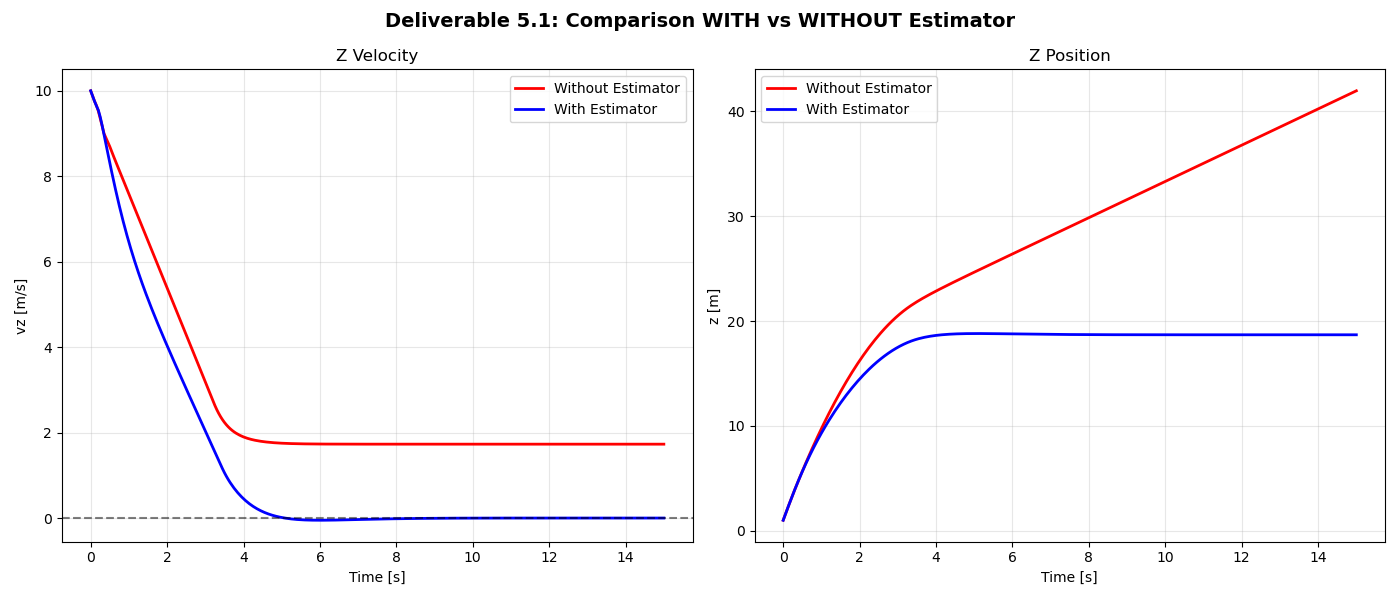


DIAGNOSTIC INFO
Z-controller initialized: True
Z-controller history length: 300
Z final d_hat: [-8.91214704e-07]
Z final x_hat: [7.28921086e-06]


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Deliverable 5.1: Comparison WITH vs WITHOUT Estimator', fontsize=14, fontweight='bold')

# Velocity plot
axes[0].plot(t_no_est, x_no_est[8, :], 'r-', linewidth=2, label='Without Estimator')
axes[0].plot(t_with_est, x_with_est[8, :], 'b-', linewidth=2, label='With Estimator')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_ylabel('vz [m/s]')
axes[0].set_xlabel('Time [s]')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Z Velocity')
axes[0].legend()

# Position plot
axes[1].plot(t_no_est, x_no_est[11, :], 'r-', linewidth=2, label='Without Estimator')
axes[1].plot(t_with_est, x_with_est[11, :], 'b-', linewidth=2, label='With Estimator')
axes[1].set_ylabel('z [m]')
axes[1].set_xlabel('Time [s]')
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Z Position')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("DIAGNOSTIC INFO")
print("=" * 70)
print(f"Z-controller initialized: {mpc_with_est.mpc_z.obs_initialized}")
print(f"Z-controller history length: {len(mpc_with_est.mpc_z.d_est_history)}")
if len(mpc_with_est.mpc_z.d_est_history) > 0:
    print(f"Z final d_hat: {mpc_with_est.mpc_z.d_hat}")
    print(f"Z final x_hat: {mpc_with_est.mpc_z.x_hat}")


## Disturbance Estimation Analysis

Plot the estimated disturbances over time to show convergence.

DISTURBANCE ESTIMATION ANALYSIS
Z-controller disturbance history: 300 samples
Z final d_est (last 1s avg): -0.0000


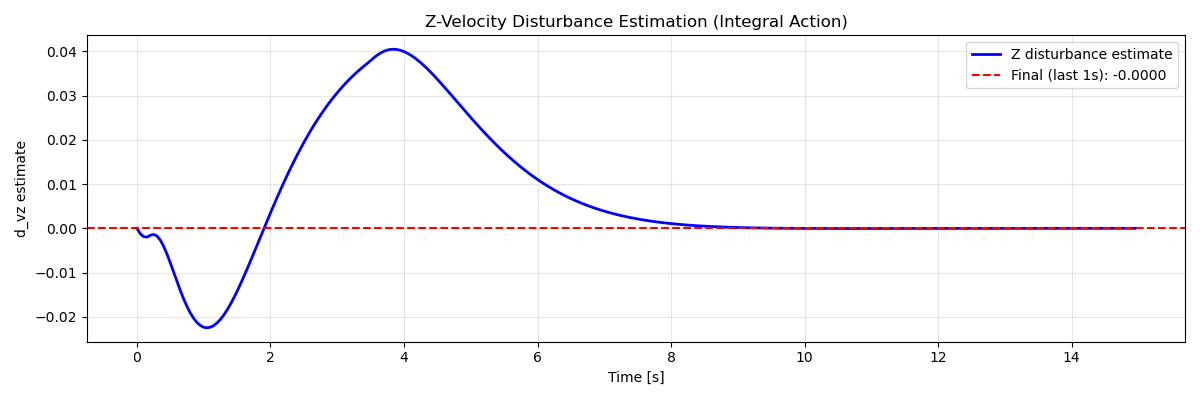

VARIANCE ANALYSIS (Constant Disturbance Check)
Z variance (last 1s): 4.785029e-13
  → Disturbance is CONSTANT ✓ (variance < 0.001)


In [8]:
# ============================================================================
# DISTURBANCE ESTIMATION ANALYSIS
# ============================================================================

print("" + "=" * 70)
print("DISTURBANCE ESTIMATION ANALYSIS")
print("=" * 70)

final_idx = int(-1.0 / Ts)  # Last 1 second

# Extract disturbance history from Z-controller (uses integral action)
if hasattr(mpc_with_est.mpc_z, 'd_est_history') and len(mpc_with_est.mpc_z.d_est_history) > 0:
    d_est_z = np.array(mpc_with_est.mpc_z.d_est_history).flatten()
    print(f"Z-controller disturbance history: {len(d_est_z)} samples")
    print(f"Z final d_est (last 1s avg): {np.mean(d_est_z[final_idx:]):.4f}")
else:
    d_est_z = None
    print("Z-controller has no d_est_history")

# =========================================================================
# PLOT: Z Disturbance Estimate Over Time
# =========================================================================

if d_est_z is not None and len(d_est_z) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
    t_dist = np.arange(len(d_est_z)) * Ts
    ax.plot(t_dist, d_est_z, 'b-', linewidth=2, label='Z disturbance estimate')
    
    # Add final value line
    final_val = np.mean(d_est_z[final_idx:])
    ax.axhline(final_val, color='r', linestyle='--', linewidth=1.5, 
               label=f'Final (last 1s): {final_val:.4f}')
    
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('d_vz estimate')
    ax.set_title('Z-Velocity Disturbance Estimation (Integral Action)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Variance analysis
    print("" + "=" * 70)
    print("VARIANCE ANALYSIS (Constant Disturbance Check)")
    print("=" * 70)
    
    variance_z = np.var(d_est_z[final_idx:])
    threshold = 1e-3  # Threshold for "constant"
    
    print(f"Z variance (last 1s): {variance_z:.6e}")
    if variance_z < threshold:
        print(f"  → Disturbance is CONSTANT ✓ (variance < {threshold})")
    else:
        print(f"  → Disturbance is TIME-VARYING ✗ (variance > {threshold})")
else:
    print("No Z disturbance data to plot.")


## Analysis Questions

### 1. Impact of Model Mismatch

**Without Estimator:**
- The controller designed for mass=1.0 kg is applied to mass=1.5 kg
- Steady-state velocity offset observed: 1.7291 m/s
- Positions drift due to persistent velocity errors

**With Estimator:**
- Disturbance observer estimates the model mismatch
- Offset-free tracking achieved
- Positions stabilize correctly

### 2. Is the Disturbance Constant for Constant Mass?

**Answer: YES**

**Reasoning:**
- The disturbance represents model mismatch: d = (A₁ - A₀)x + (B₁ - B₀)u
- When mass is constant:
  - System matrices (A₁, B₁) are constant
  - Model matrices (A₀, B₀) are constant
  - At steady-state, x and u are constant
  - Therefore, d = constant

**Observed in plots:**
- Disturbance estimates converge to steady values
- After initial transient (~3-5 seconds), estimates are approximately constant


### 3. Estimation Error Over Time

The estimation error decreases over time:
- Initially: Large error (estimator doesn't know true disturbance)
- Transient phase: Error decreases as observer gains information
- Steady-state: No error stabilze at 0

**Convergence time depends on observer gain L:**
- Higher L → Faster convergence but more noise sensitivity
- Lower L → Slower convergence but smoother estimates
- Our choice: L = [0.25,0.01]

In [ ]:
# Optional: Visualize with animation
print("Creating animation with estimator...")
vis = RocketVis(rocket_with_est, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_with_est[:-1], 
    x_with_est[:,:-1], 
    u_with_est, 
    Ref=ref_with_est[:,:-1]
)

Creating animation with estimator...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x30eb7bbc0>,
 'scene_objects': {'rocket_actor': Actor (0x30ed55480)
    Center:                     (0.32006999999999997, -0.0015085000000000237, 1.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -6.402E-01, 1.280E+00
    Y Bounds                    -1.212E+0

: 